In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
# from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Load the csv file that has been preprocessed in the previous step
df = pd.read_csv('airbnb_mel_log_prep_02.csv')
df.head()

,price,price_binned,price_log,host_months,host_is_superhost,host_listings_count,host_identity_verified,lat_long_interaction,accommodates,bathrooms,...,minimum_nights,maximum_nights,availability_30,availability_365,instant_bookable,listings_in_neighbourhood,number_of_reviews_ltm,listing_active_months,has_description,has_neighborhood_overview
0,56.0,"(15.999, 102.0]",4.025352,180,1,1.0,1,-5475.304873,2,1.0,...,7,29,1,301,0,598,22,139.597536,1,1
1,119.0,"(102.0, 139.0]",4.779123,170,1,1.0,1,-5531.230958,5,1.0,...,1,14,20,306,0,246,25,165.092402,1,1
2,186.0,"(180.0, 259.0]",5.225747,169,1,2.0,1,-5482.014220,4,1.0,...,21,90,9,222,0,5913,12,77.240246,0,1
3,123.0,"(102.0, 139.0]",4.812184,169,1,6.0,1,-5499.863771,2,1.0,...,2,1125,11,302,0,443,11,161.872690,1,1
4,89.0,"(15.999, 102.0]",4.488636,169,1,8.0,1,-5536.893133,2,1.5,...,5,45,15,92,0,238,6,161.905544,1,1


In [4]:
# Set features and target variable
X = df.drop(['price', 'price_binned', 'price_log'], axis=1)
y = df['price_log']
y_bin = df['price_binned']

In [5]:
# Set random seed for reproducibility
seed = 42

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y_bin
)

In [6]:
## Use logged price as target for training

# Define models including Linear Regression, Ridge, KNN (instance-based), and ensemble models (tree-based)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Extra Trees": ExtraTreesRegressor(random_state=seed), # too slow
    "XGBoost": XGBRegressor(random_state=seed),
    "LightGBM": LGBMRegressor(random_state=seed, verbose=0)     
}

# Function to calculate Adjusted R²
def adjusted_r2(r2, n_observations, k_features):
    return 1 - (1 - r2) * (n_observations - 1) / (n_observations - k_features - 1)

# Function to evaluate models with cross-validation
def evaluate_model_cv_log(model, X, y_log, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)
    
    r2_scores, adj_r2_scores = [], []
    r2_log_scores, adj_r2_log_scores = [], []
    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []
    train_times, predict_times = [], []
    
    n_samples, n_features = X.shape

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_log, y_test_log = y_log.iloc[train_index], y_log.iloc[test_index]
        
        # Scale the data within the fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model and record training time
        start_time = time.time()
        model.fit(X_train_scaled, y_train_log)
        train_time = time.time() - start_time
        
        # Make predictions and record prediction time
        start_time = time.time()
        y_pred_log = model.predict(X_test_scaled)
        predict_time = time.time() - start_time
      
        # Compute R² and Adjusted R² on log scale
        r2_log = r2_score(y_test_log, y_pred_log)
        adj_r2_log = adjusted_r2(r2_log, len(y_test_log), n_features)
        r2_log_scores.append(r2_log)
        adj_r2_log_scores.append(adj_r2_log)
        
        ###########
        # Ensure no negative or zero values in y_test_log and y_pred_log
        if np.any(y_test_log <= 0) or np.any(y_pred_log <= 0):
            print("Error: Log transformation applied to non-positive values.")        
        

        # Exponentiate predictions and actuals to get original scale
        y_test_exp = np.exp(y_test_log)
        # Exponentiate predictions with bias correction
        sigma_squared = np.var(y_test_log - y_pred_log)
        y_pred_exp = np.exp(y_pred_log + sigma_squared / 2)

        ####################
        # Check for infinite or NaN values
        if np.any(np.isinf(y_test_exp)) or np.any(np.isnan(y_test_exp)):
            print("Warning: y_test_exp contains infinite or NaN values.")
        if np.any(np.isinf(y_pred_exp)) or np.any(np.isnan(y_pred_exp)):
            print("Warning: y_pred_exp contains infinite or NaN values.")


        
        # Compute evaluation metrics on original scale
        r2 = r2_score(y_test_exp, y_pred_exp)
        adj_r2 = adjusted_r2(r2, len(y_test_exp), n_features)
        mse = mean_squared_error(y_test_exp, y_pred_exp)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_exp, y_pred_exp)
        mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp) * 100  # MAPE in percentage
        
        # Append metrics
        r2_scores.append(r2)
        adj_r2_scores.append(adj_r2)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)
        train_times.append(train_time)
        predict_times.append(predict_time)
    
    # Calculate average metrics across folds
    adj_r2_avg = np.mean(adj_r2_scores)
    adj_r2_log_avg = np.mean(adj_r2_log_scores)
    mse_avg = np.mean(mse_scores)
    rmse_avg = np.mean(rmse_scores)
    mae_avg = np.mean(mae_scores)
    mape_avg = np.mean(mape_scores)
    train_time_avg = np.mean(train_times)
    predict_time_avg = np.mean(predict_times)
    
    return adj_r2_log_avg, adj_r2_avg, rmse_avg, mae_avg, mape_avg, train_time_avg, predict_time_avg

# Baseline model comparison with cross-validation
def baseline_model_comparison_cv_log(models, X, y_log, cv=3):
    results = []
    for name, model in models.items():
        adj_r2_log, adj_r2, rmse, mae, mape, train_time, predict_time = evaluate_model_cv_log(model, X, y_log, cv=cv)
        results.append({
            "Model": name,
            "Adjusted R²_Log": adj_r2_log,
            "Adjusted R²": adj_r2,
            "MAPE (%)": mape,
            "MAE": mae,
            "RMSE": rmse,
            
            
            "Training Time": train_time,
            "Prediction Time": predict_time
        })
    # Sort by Adjusted R² on original scale
    return pd.DataFrame(results).sort_values("Adjusted R²", ascending=False)

# Perform cross-validation based baseline comparison for training data
results_df_cv = baseline_model_comparison_cv_log(models, X_train, y_train, cv=3)

# Display the results
results_df_cv


,Model,Adjusted R²_Log,Adjusted R²,MAPE (%),MAE,RMSE,Training Time,Prediction Time
5,LightGBM,0.738661,0.619307,23.956563,47.383991,84.860521,0.131549,0.006106
4,XGBoost,0.728360,0.602893,24.581420,48.693899,86.628581,0.157374,0.003002
3,Extra Trees,0.721152,0.583071,24.603729,48.870025,88.804318,3.751878,0.085524
2,KNN,0.605529,0.457779,29.419606,57.612270,101.268349,0.001667,0.100017
0,Linear Regression,0.595208,0.437857,32.145934,60.889014,103.120090,0.021671,0.000666
1,Ridge Regression,0.595210,0.437820,32.145873,60.889614,103.123506,0.003320,0.000976


In [7]:
# Initialise LightGBM model
lgbm_model = LGBMRegressor(random_state=seed, verbose=0)

# Initialise KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create a pipeline to scale features and perform RFECV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfecv', RFECV(
        estimator=lgbm_model,
        step=1,
        cv=kf,
        scoring='neg_mean_absolute_error',
        verbose=2
    ))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get the selected features
rfecv = pipeline.named_steps['rfecv']
selected_features = X.columns[rfecv.support_]

print("Selected Features:")
print(selected_features)
print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 featur

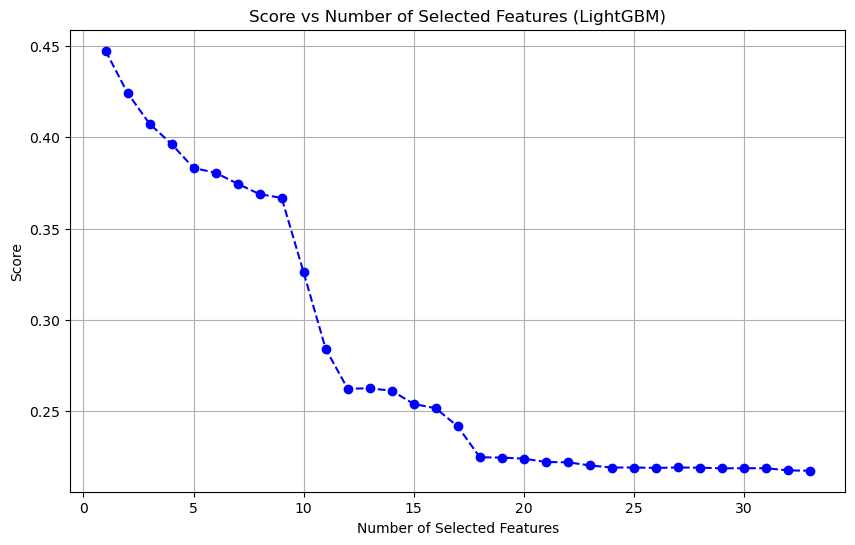

In [8]:
# Extract the cross-validation results (in the newer versions of sklearn)
score_values = -rfecv.cv_results_['mean_test_score']

# Plot the evaluation score against the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(score_values) + 1), score_values, marker='o', linestyle='--', color='b')
plt.title("Score vs Number of Selected Features (LightGBM)")
plt.xlabel("Number of Selected Features")
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [9]:
# Check the top features selected by LightGBM
# lgbm_model = LGBMRegressor(random_state=seed, verbose=0)
top_n = 25

# Fit LightGBM model on all features
lgbm_model.fit(X_train, y_train)

# Get feature importances
importances = lgbm_model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top n features
selected_features = feature_importances['Feature'][:top_n]

selected_features_list = selected_features.tolist()

print(f"Selected Features (based on importance):\n ")
selected_features_list

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Selected Features (based on importance):
 


['host_listings_count',
 'distance_km_to_yarra_ranges',
 'number_of_reviews_ltm',
 'host_months',
 'availability_365',
 'distance_km_to_city',
 'amenities_count',
 'availability_30',
 'lat_long_interaction',
 'distance_km_to_airport',
 'listings_in_neighbourhood',
 'listing_active_months',
 'accommodates',
 'maximum_nights',
 'minimum_nights',
 'bathrooms',
 'bedrooms_num_cap',
 'room_type_Private room',
 'host_is_superhost',
 'beds_num_cap',
 'property_type_category_Hospitality',
 'instant_bookable',
 'property_type_category_Rental Unit',
 'is_shared_bath',
 'room_type_Shared room']

In [10]:
X_train[selected_features].head()

,host_listings_count,distance_km_to_yarra_ranges,number_of_reviews_ltm,host_months,availability_365,distance_km_to_city,amenities_count,availability_30,lat_long_interaction,distance_km_to_airport,...,bathrooms,bedrooms_num_cap,room_type_Private room,host_is_superhost,beds_num_cap,property_type_category_Hospitality,instant_bookable,property_type_category_Rental Unit,is_shared_bath,room_type_Shared room
1226,1.0,55.892847,19,96,321,5.268219,49,20,-5488.787906,24.312312,...,1.0,1.0,False,1,2.0,False,1,True,0,False
12923,22.0,60.986289,8,101,88,5.234559,36,28,-5477.367454,15.574050,...,2.0,2.0,False,0,2.0,False,0,True,0,False
256,2.0,54.455794,0,123,309,4.112589,12,0,-5477.123885,17.213773,...,1.0,2.0,True,0,2.0,False,0,False,1,False
5805,1.0,56.541878,22,79,88,1.014819,45,28,-5482.766998,20.027927,...,1.0,1.0,True,1,1.0,False,0,True,1,False
6834,104.0,55.912870,63,151,229,1.872356,42,16,-5484.149411,21.115065,...,2.0,2.0,False,1,2.0,False,1,True,0,False


In [11]:
# Quick check
results_selected = baseline_model_comparison_cv_log(models, X_train[selected_features], y_train, cv=3)
print(X_train[selected_features].shape)
results_selected

(11844, 25)


,Model,Adjusted R²_Log,Adjusted R²,MAPE (%),MAE,RMSE,Training Time,Prediction Time
5,LightGBM,0.736812,0.620776,24.101202,47.502393,84.781475,0.122420,0.005332
4,XGBoost,0.723289,0.601907,24.769896,48.955190,86.866573,0.156484,0.003665
3,Extra Trees,0.725134,0.591501,24.467463,48.581348,87.989146,3.109402,0.070813
2,KNN,0.624151,0.473911,28.804886,56.551830,99.831373,0.001340,0.045821
0,Linear Regression,0.587136,0.435768,32.473567,61.331122,103.416793,0.008820,0.000671
1,Ridge Regression,0.587138,0.435737,32.473650,61.331564,103.419599,0.002321,0.000698


## Hyperparam tuning with the selected features

In [ ]:
## Hyperparameter Tuning for top models (based on Adjusted R² results and training time)

# Define parameter spaces for each model
lightgbm_params = {
    'num_leaves': [31, 64, 128, 256, 512],
    'max_depth': [-1, 10, 20, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 700, 1000], 
    'min_data_in_leaf': [5, 10, 20],
    'min_child_weight': [1e-3, 0.01, 0.1, 1],
    'max_bin': [255, 300, 500, 1000],
    'lambda_l1': [0, 0.1, 1, 5],
    'lambda_l2': [0, 0.1, 1, 5],
    'min_split_gain': [0, 0.1, 0.5, 1],
    'boosting_type': ['gbdt', 'dart', 'goss'],
}

xgboost_params = {
    'max_depth': [3, 5, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 700, 1000],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

knn_params = {
    'n_neighbors': [3, 5, 15, 25],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}


# Define the models and parameter grids
models_info = [
    # Models that do not require scaling (tree-based models)
    ('LightGBM', LGBMRegressor(random_state=seed, verbose=0), lightgbm_params, False),
    ('XGBoost', XGBRegressor(random_state=seed), xgboost_params, False),

    # Models that require scaling (linear models)
    ('Linear Regression', LinearRegression(), {}, True),
    ('KNN', KNeighborsRegressor(), knn_params, True)
]

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Initialize lists to store results
results_list = []
best_estimators = {}
best_params = {}
all_predictions = {}

# Use the selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

for model_name, model, params, needs_scaling in models_info:
    # Create a pipeline with scaling if necessary
    if needs_scaling:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        # Adjust parameter grid to match the pipeline structure
        pipeline_params = {
            f'model__{key}': value for key, value in params.items()
        }
    else:
        pipeline = Pipeline([
            ('model', model)
        ])
        pipeline_params = {
            f'model__{key}': value for key, value in params.items()
        }

    # Perform RandomizedSearchCV with the pipeline
    random_search = RandomizedSearchCV(
        pipeline, pipeline_params, n_iter=50, cv=kf,
        scoring='neg_mean_absolute_error', n_jobs=-1, random_state=seed
    )

    # Fit the model and record training time
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Get the best estimator and parameters
    best_estimator = random_search.best_estimator_
    best_param = random_search.best_params_

    # Store best estimator and parameters
    best_estimators[model_name] = best_estimator
    best_params[model_name] = best_param

    # Record prediction time
    start_time = time.time()
    y_pred_log = best_estimator.predict(X_test)
    prediction_time = time.time() - start_time

    # Exponentiate predictions and actuals to get original scale
    y_test_exp = np.exp(y_test)
    # Bias correction when exponentiating predictions
    sigma_squared = np.var(y_test - y_pred_log)
    y_pred_exp = np.exp(y_pred_log + sigma_squared / 2)

    n = len(y_test)  # number of samples
    p = X_test.shape[1]  # number of features

    # Compute evaluation metrics on log scale
    r2_log = r2_score(y_test, y_pred_log)
    adj_r2_log = adjusted_r2(r2_log, n, p)  # 1 - (1 - r2_log) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    # Compute evaluation metrics on original scale
    r2 = r2_score(y_test_exp, y_pred_exp)
    adj_r2 = adjusted_r2(r2, n, p)  # 1 - (1 - r2) * (len(y_test_exp) - 1) / (len(y_test_exp) - X_test.shape[1] - 1)
    mse = mean_squared_error(y_test_exp, y_pred_exp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp) * 100  # MAPE in percentage

    # Append results with specified precision
    results_list.append({
        'Model': model_name,
        'Adjusted R²_Log': round(adj_r2_log, 3),
        'Adjusted R²': round(adj_r2, 3),
        'MAPE (%)': round(mape, 2),
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'Training Time': round(training_time, 2),
        'Prediction Time': round(prediction_time, 3)
    })

    # Store predictions for further analysis if needed
    all_predictions[model_name] = {
        'y_pred_log': y_pred_log,
        'y_pred_exp': y_pred_exp,
        'y_test_exp': y_test_exp
    }

# Create a DataFrame from the results
final_results_df = pd.DataFrame(results_list)

# Reorder columns
final_results_df = final_results_df[[
    'Model', 'Adjusted R²_Log', 'Adjusted R²', 'MAPE (%)', 'MAE', 'RMSE',
    'Training Time', 'Prediction Time'
]]


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 w

In [13]:
# Display the results sorted by Adjusted R²
final_results_df = final_results_df.sort_values('Adjusted R²_Log', ascending=False)

# Print the final results
final_results_df

,Model,Adjusted R²_Log,Adjusted R²,MAPE (%),MAE,RMSE,Training Time,Prediction Time
1,XGBoost,0.777,0.674,21.87,43.28,77.61,74.26,0.020
0,LightGBM,0.772,0.669,22.17,44.06,78.17,491.14,0.032
3,KNN,0.704,0.559,25.06,49.63,90.19,5.80,0.117
2,Linear Regression,0.599,0.463,32.48,60.23,99.54,0.36,0.003


In [14]:
for model_name in best_params:
    print(f"Best parameters for {model_name}:")
    print(best_params[model_name])
    print()

Best parameters for LightGBM:
{'model__num_leaves': 64, 'model__n_estimators': 700, 'model__min_split_gain': 0, 'model__min_data_in_leaf': 10, 'model__min_child_weight': 0.001, 'model__max_depth': 20, 'model__max_bin': 255, 'model__learning_rate': 0.05, 'model__lambda_l2': 5, 'model__lambda_l1': 1, 'model__boosting_type': 'gbdt'}

Best parameters for XGBoost:
{'model__subsample': 0.6, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0, 'model__n_estimators': 700, 'model__min_child_weight': 3, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 0.6}

Best parameters for Linear Regression:
{}

Best parameters for KNN:
{'model__weights': 'distance', 'model__n_neighbors': 15, 'model__metric': 'manhattan'}



In [15]:
# Access the best XGBoost model
best_xgb = best_estimators['XGBoost'].named_steps['model']

# Get the feature importances
importances = best_xgb.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances for XGBoost:")
importance_df


Feature Importances for XGBoost:


,Feature,Importance
17,room_type_Private room,0.454371
16,bedrooms_num_cap,0.151106
23,is_shared_bath,0.086040
20,property_type_category_Hospitality,0.066950
24,room_type_Shared room,0.046504
12,accommodates,0.036622
15,bathrooms,0.022935
10,listings_in_neighbourhood,0.016839
19,beds_num_cap,0.010638
0,host_listings_count,0.009588


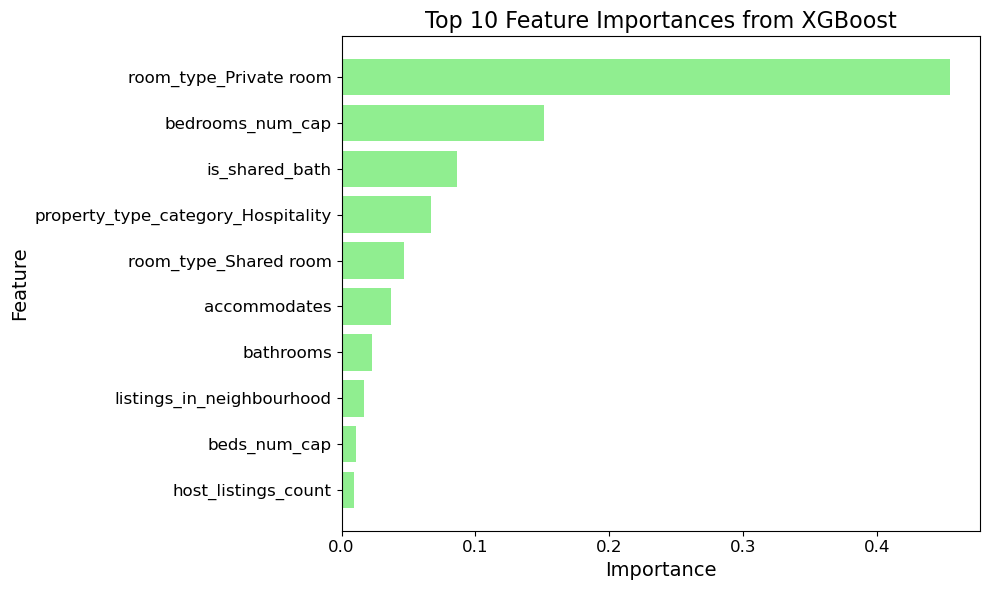

In [16]:
# Select the top 10 features
top_features = importance_df.head(10)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='lightgreen')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Feature Importances from XGBoost', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [17]:
# Access the best LightGBM model
best_lgbm = best_estimators['LightGBM'].named_steps['model']

# Get the feature importances
importances = best_lgbm.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances for LightGBM:")
importance_df


Feature Importances for LightGBM:


,Feature,Importance
3,host_months,4239
4,availability_365,4098
1,distance_km_to_yarra_ranges,3706
6,amenities_count,3499
11,listing_active_months,3492
0,host_listings_count,3374
5,distance_km_to_city,3207
8,lat_long_interaction,2935
2,number_of_reviews_ltm,2906
7,availability_30,2403


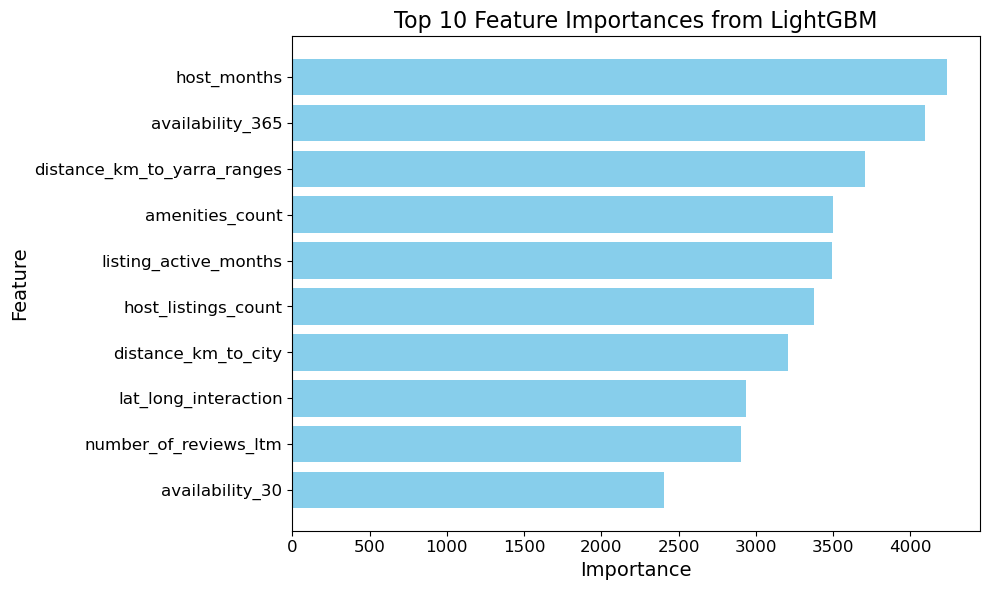

In [18]:
# Select the top 10 features
top_features = importance_df.head(10)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Feature Importances from LightGBM', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

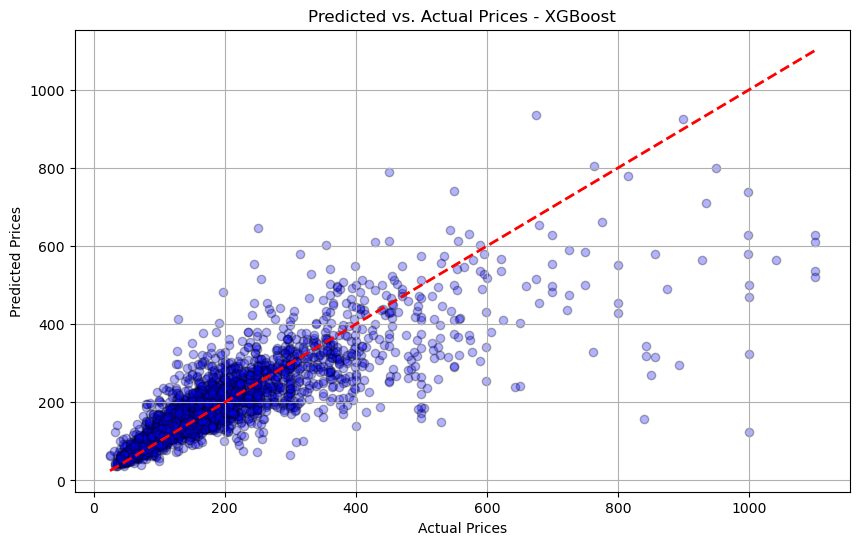

In [19]:
# Predicted vs. Actual Values Plot
model_name = 'XGBoost'  

# Extract the predicted and actual values
y_pred_exp = all_predictions[model_name]['y_pred_exp']
y_test_exp = all_predictions[model_name]['y_test_exp']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.3, color='blue', edgecolors='k')
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Predicted vs. Actual Prices - {model_name}')
plt.grid(True)
plt.show()


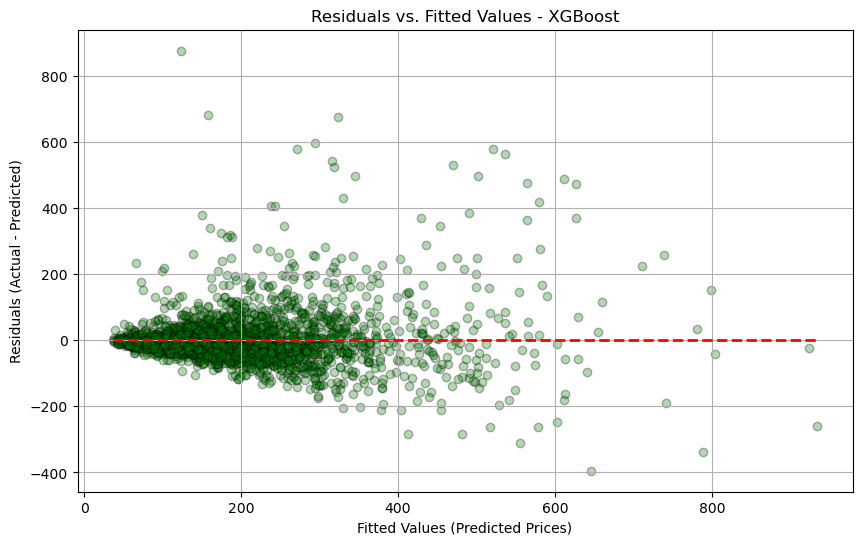

In [20]:
# Residuals vs. Fitted Values Plot
model_name = 'XGBoost'
residuals = y_test_exp - y_pred_exp

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_exp, residuals, alpha=0.3, color='green', edgecolors='k')
plt.hlines(y=0, xmin=y_pred_exp.min(), xmax=y_pred_exp.max(), colors='r', linestyles='--', lw=2)
plt.xlabel('Fitted Values (Predicted Prices)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residuals vs. Fitted Values - {model_name}')
plt.grid(True)
plt.show()


In [21]:
def plot_model_diagnostics(model_name, all_predictions):
    # Extract predictions and actual values
    y_pred_exp = all_predictions[model_name]['y_pred_exp']
    y_test_exp = all_predictions[model_name]['y_test_exp']
    
    # Calculate residuals
    residuals = y_test_exp - y_pred_exp
    
    # Predicted vs. Actual Values Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_exp, y_pred_exp, alpha=0.3, color='blue', edgecolors='k')
    plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Predicted vs. Actual Prices - {model_name}')
    plt.grid(True)
    plt.show()
    
    # Residuals vs. Fitted Values Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_exp, residuals, alpha=0.3, color='green', edgecolors='k')
    plt.hlines(y=0, xmin=y_pred_exp.min(), xmax=y_pred_exp.max(), colors='r', linestyles='--', lw=2)
    plt.xlabel('Fitted Values (Predicted Prices)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residuals vs. Fitted Values - {model_name}')
    plt.grid(True)
    plt.show()


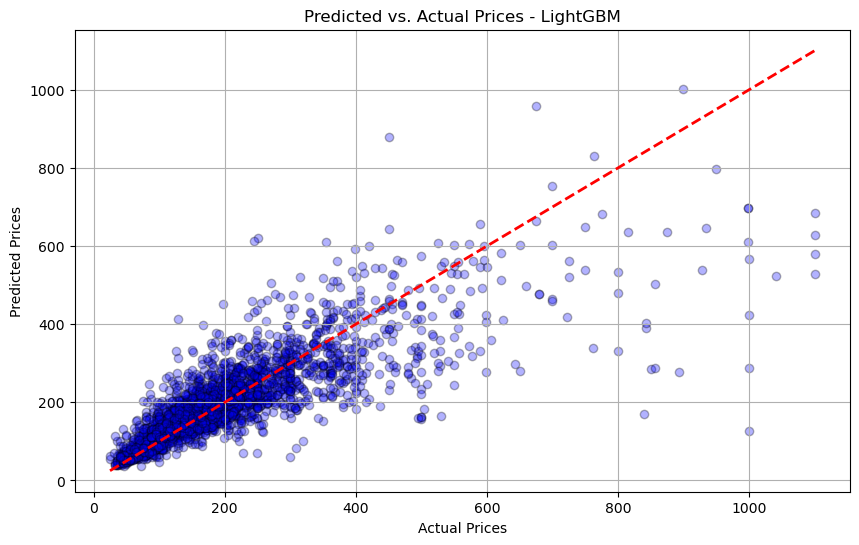

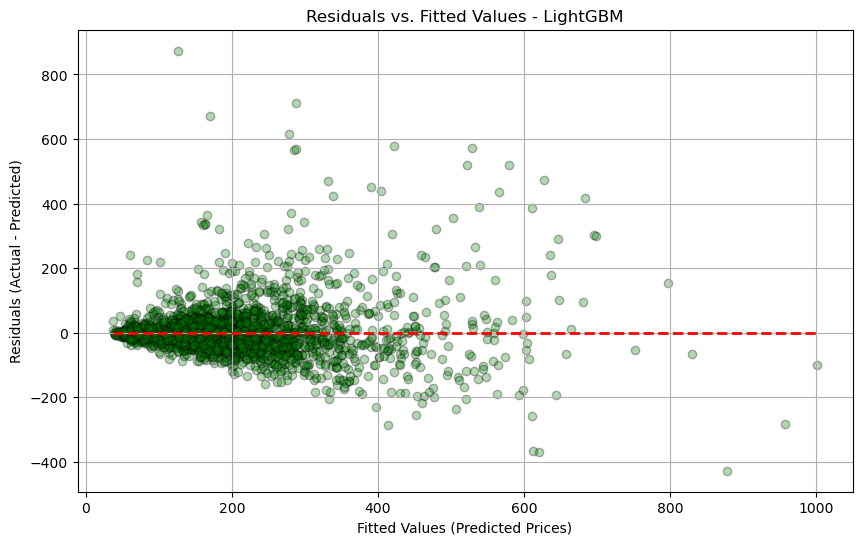

In [22]:
# Plot diagnostics for LightGBM
plot_model_diagnostics('LightGBM', all_predictions)

In [23]:
# Ensure y_test_exp and y_pred_exp are pandas Series with the same index as X_test
# If they are numpy arrays, convert them to Series and align indices
y_test_exp = pd.Series(all_predictions[model_name]['y_test_exp'], index=X_test.index)
y_pred_exp = pd.Series(all_predictions[model_name]['y_pred_exp'], index=X_test.index)

# Calculate residuals
residuals = y_test_exp - y_pred_exp

# Define the condition
condition = residuals > 500

# Get the indices of data points that satisfy the condition
indices = residuals[condition].index


In [24]:
# Extract the features for these indices
outlier_X = X_test.loc[indices]

# Extract the actual and predicted prices and residuals
outlier_y_actual = y_test_exp.loc[indices]
outlier_y_pred = y_pred_exp.loc[indices]
outlier_residuals = residuals.loc[indices]

# Combine into a DataFrame for easier analysis
outliers_df = outlier_X.copy()
outliers_df['Actual Price'] = outlier_y_actual
outliers_df['Predicted Price'] = outlier_y_pred
outliers_df['Residual'] = outlier_residuals




In [25]:
# Display the DataFrame
outliers_df.T

,1807,10494,1211,7199,14417,4850,2585,1233,9588,3698
host_listings_count,1.0,2.0,1.0,30.0,4.0,9.0,1.0,1.0,3.0,4.0
distance_km_to_yarra_ranges,54.908817,41.12061,56.219987,59.947575,39.627537,41.204188,58.051488,22.816117,55.433724,57.145384
number_of_reviews_ltm,0,2,0,8,1,3,10,34,1,0
host_months,145,100,96,138,63,39,149,106,15,59
availability_365,140,177,179,213,330,89,65,316,141,138
distance_km_to_city,1.80889,18.576801,5.415551,38.626244,74.674347,17.446346,37.22119,38.43817,2.983468,1.018872
amenities_count,19,32,10,34,18,31,30,69,51,35
availability_30,16,29,29,24,25,29,4,20,0,0
lat_long_interaction,-5480.214077,-5498.369276,-5474.342513,-5534.680347,-5551.136688,-5496.074092,-5532.616132,-5507.160315,-5485.664738,-5480.858409
distance_km_to_airport,18.857691,36.321606,14.842769,57.623585,91.688697,34.863518,56.323298,53.81664,22.26018,18.597427
